# About
This notebook is used to show how the SLR models used in Pletcher et al. (2025) are trained and tested.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
import sys

from glob import glob
from copy import copy
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

sys.path.append('../scripts/utils/')
import train

sys.path.append('../scripts/plotting_scripts/')
import verification_plots

# Globals

In [2]:
LEVELS = range(3, 24 + 1, 3) # 300 m, 600 m ... 2400 m AGL
ATMOS_FEATURES = (
    ['SPD%02dK' % i for i in LEVELS] + # Wind speed
    ['T%02dK' % i for i in LEVELS] + # Temperature
    ['R%02dK' % i for i in LEVELS] # Relative humidity
)
GEOG_FEATURES = ['lat', 'lon', 'elev'] # station latitude, longitude, and elevation

TRAIN_SIZE, TEST_SIZE = 0.6, 0.4
N_ITER = 100 

# Read in ERA5 train/validate dataset

In [3]:
data = pd.read_pickle('../data/train-validate/ERA5_train-validate_dataset_raw.pickle')

In [4]:
# Ensure data does not contain any events after October 2022
# so that the train/test and validation dataset dates are separate
data = data.reset_index().set_index('datetime_utc')
data.index = pd.to_datetime(data.index)
data = data[(data.index.year < 2022) | ((data.index.year == 2022) & (data.index.month < 11))]
data = data.rename(columns = {'site_elev' : 'elev', 'site_lat' : 'lat', 'site_lon' : 'lon'})

# Train and test simple linear regression model

In [5]:
# Configure settings for linear regression
MODEL_TYPE = 'lr' # Options are lr (linear regression) and rf (random forest)
FEATURES = ATMOS_FEATURES + GEOG_FEATURES if MODEL_TYPE == 'RF' else ATMOS_FEATURES

# Empty lists for each performance metric
mae, r2, rmse, bias = [], [], [], []
for i in range(0, N_ITER):
    
    # Build datasets
    X_train, X_test, y_train, y_test = train.build_train_test_data(
        data,
        label = 'slr',
        train_size = TRAIN_SIZE,
        test_size = TEST_SIZE,
    )
    X_train = X_train.reset_index()
    
    # Train model
    test_predictions, y_test, model = train.train_model(
        X_train,
        X_test,
        y_train,
        y_test,
        features = FEATURES,
        model_type = MODEL_TYPE,
    )
    
    # Evaluate model
    metrics = train.evaluate_model(y_test, test_predictions)
    
    # Append metrics to empty lists
    mae.append(metrics['MAE']) # Mean absolute error
    rmse.append(metrics['RMSE']) # Root mean squared error
    r2.append(metrics['R2']) # Coefficient of determination
    bias.append(metrics['MBE']) # Mean bias error

agg_metrics = {
    'Agg-MAE' : np.mean(mae),
    'Agg-R2' : np.mean(r2),
    'Agg-RMSE' : np.mean(rmse),
    'Agg-MBE' : np.mean(bias),
}

print('MAE from %s iterations: %s' % (N_ITER, agg_metrics['Agg-MAE']))
print('Mean R2 from %s iterations: %s' % (N_ITER, agg_metrics['Agg-R2']))
print('Mean RMSE from %s iterations: %s' % (N_ITER, agg_metrics['Agg-RMSE']))
print('MBE from %s iterations: %s' % (N_ITER, agg_metrics['Agg-MBE']))

Elapsed time to train and make predictions: 0.09
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.03
Elapsed time to train and make predictions: 0.02
Elapsed time to train and make predictions: 0.02
Elapsed time to train and make predictions: 0.02
Elapsed time to train and make predictions: 0.02
Elapsed time to train and make predictions: 0.02
Elapsed time to trai

# Plot 2-d histogram of train-test results and aggregate statistics

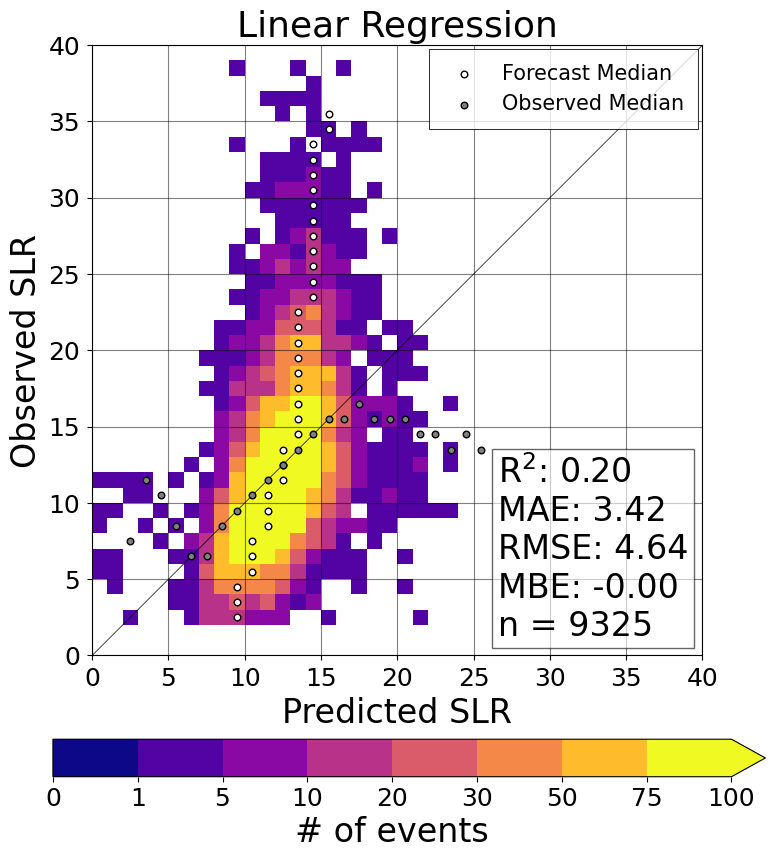

In [6]:
verification_plots.hist_2d(
    test_predictions, 
    y_test, 
    agg_metrics,
    max_value = 40,
    bin_width = 1,
    levels = None,
    title = 'Linear Regression', 
    cmap = 'plasma',
    plot_medians = True,
    cbar = True
)

# Train and test random forest model

In [7]:
# Configure settings for random forest
MODEL_TYPE = 'rf' # Options are lr (linear regression) and rf (random forest)
FEATURES = ATMOS_FEATURES + GEOG_FEATURES if MODEL_TYPE == 'rf' else ATMOS_FEATURES

# Empty lists for each performance metric
mae, r2, rmse, bias = [], [], [], []
X_trains, y_trains, models = [], [], []
for i in range(0, N_ITER):
    
    # Build datasets
    X_train, X_test, y_train, y_test = train.build_train_test_data(
        data,
        label = 'slr',
        train_size = TRAIN_SIZE,
        test_size = TEST_SIZE,
    )
    X_train = X_train.reset_index()

    # Append training features/labels for feature importances later
    X_trains.append(X_train)
    y_trains.append(y_train)
    
    # Train model
    test_predictions, y_test, model = train.train_model(
        X_train,
        X_test,
        y_train,
        y_test,
        features = FEATURES,
        model_type = MODEL_TYPE,
    )
    
    # Evaluate model
    metrics = train.evaluate_model(y_test, test_predictions)
    
    # Append metrics to empty lists
    mae.append(metrics['MAE']) # Mean absolute error
    rmse.append(metrics['RMSE']) # Root mean squared error
    r2.append(metrics['R2']) # Coefficient of determination
    bias.append(metrics['MBE']) # Mean bias error

    models.append(model)

agg_metrics = {
    'Agg-MAE' : np.mean(mae),
    'Agg-R2' : np.mean(r2),
    'Agg-RMSE' : np.mean(rmse),
    'Agg-MBE' : np.mean(bias),
}

print('MAE from %s iterations: %s' % (N_ITER, agg_metrics['Agg-MAE']))
print('Mean R2 from %s iterations: %s' % (N_ITER, agg_metrics['Agg-R2']))
print('Mean RMSE from %s iterations: %s' % (N_ITER, agg_metrics['Agg-RMSE']))
print('MBE from %s iterations: %s' % (N_ITER, agg_metrics['Agg-MBE']))

Elapsed time to train and make predictions: 7.03
Elapsed time to train and make predictions: 6.96
Elapsed time to train and make predictions: 6.95
Elapsed time to train and make predictions: 6.94
Elapsed time to train and make predictions: 6.92
Elapsed time to train and make predictions: 6.97
Elapsed time to train and make predictions: 6.96
Elapsed time to train and make predictions: 7.01
Elapsed time to train and make predictions: 6.95
Elapsed time to train and make predictions: 6.92
Elapsed time to train and make predictions: 7.01
Elapsed time to train and make predictions: 7.01
Elapsed time to train and make predictions: 6.97
Elapsed time to train and make predictions: 6.97
Elapsed time to train and make predictions: 7.31
Elapsed time to train and make predictions: 6.93
Elapsed time to train and make predictions: 6.99
Elapsed time to train and make predictions: 6.91
Elapsed time to train and make predictions: 6.95
Elapsed time to train and make predictions: 6.98
Elapsed time to trai

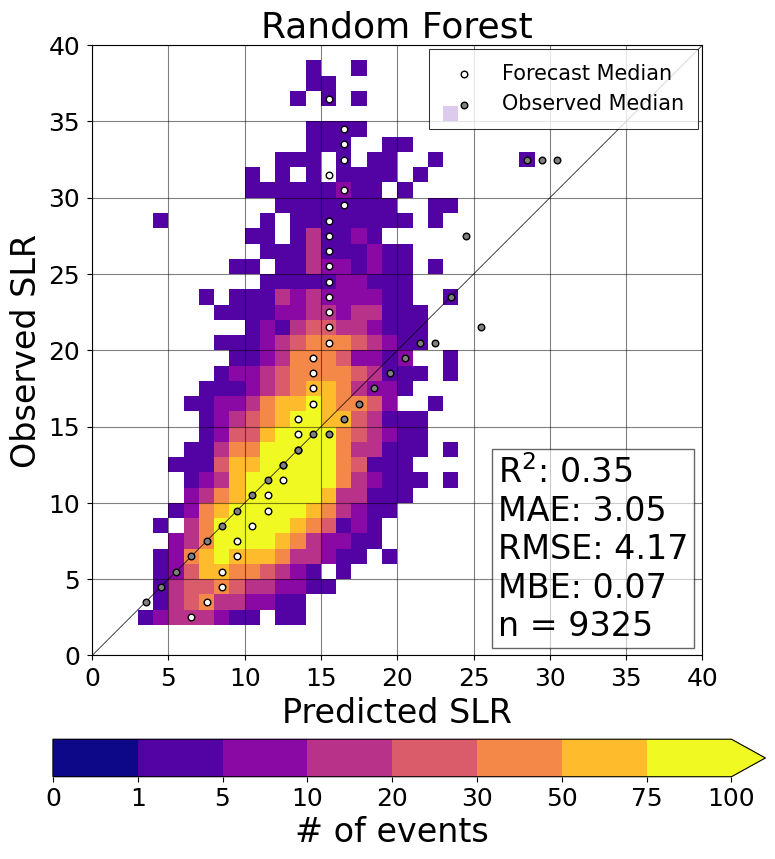

In [8]:
verification_plots.hist_2d(
    test_predictions, 
    y_test, 
    agg_metrics,
    max_value = 40,
    bin_width = 1,
    levels = None,
    title = 'Random Forest', 
    cmap = 'plasma',
    plot_medians = True,
    cbar = True
)

# Determine feature importances

In [9]:
FEATURES = (
    ['SPD%02dK' % i for i in range(3, 25, 3)] +
    ['T%02dK' % i for i in range(3, 25, 3)] +
    ['R%02dK' % i for i in range(3, 25, 3)] +
    ['lat', 'lon', 'elev']
)

X_train = X_train.filter(FEATURES)
importances_dict = {feature: [] for feature in X_train.columns}

for model, X_train, y_train in zip(models, X_trains, y_trains):
    
    X_train = X_train.filter(FEATURES)
    feat_importances = permutation_importance(model, X_train, y_train, n_repeats = 1, random_state = 42)
    for i, feature in enumerate(X_train.columns):
        importances_dict[feature].append(feat_importances.importances[i, 0])

df = pd.DataFrame(importances_dict)

# Visualize feature importances

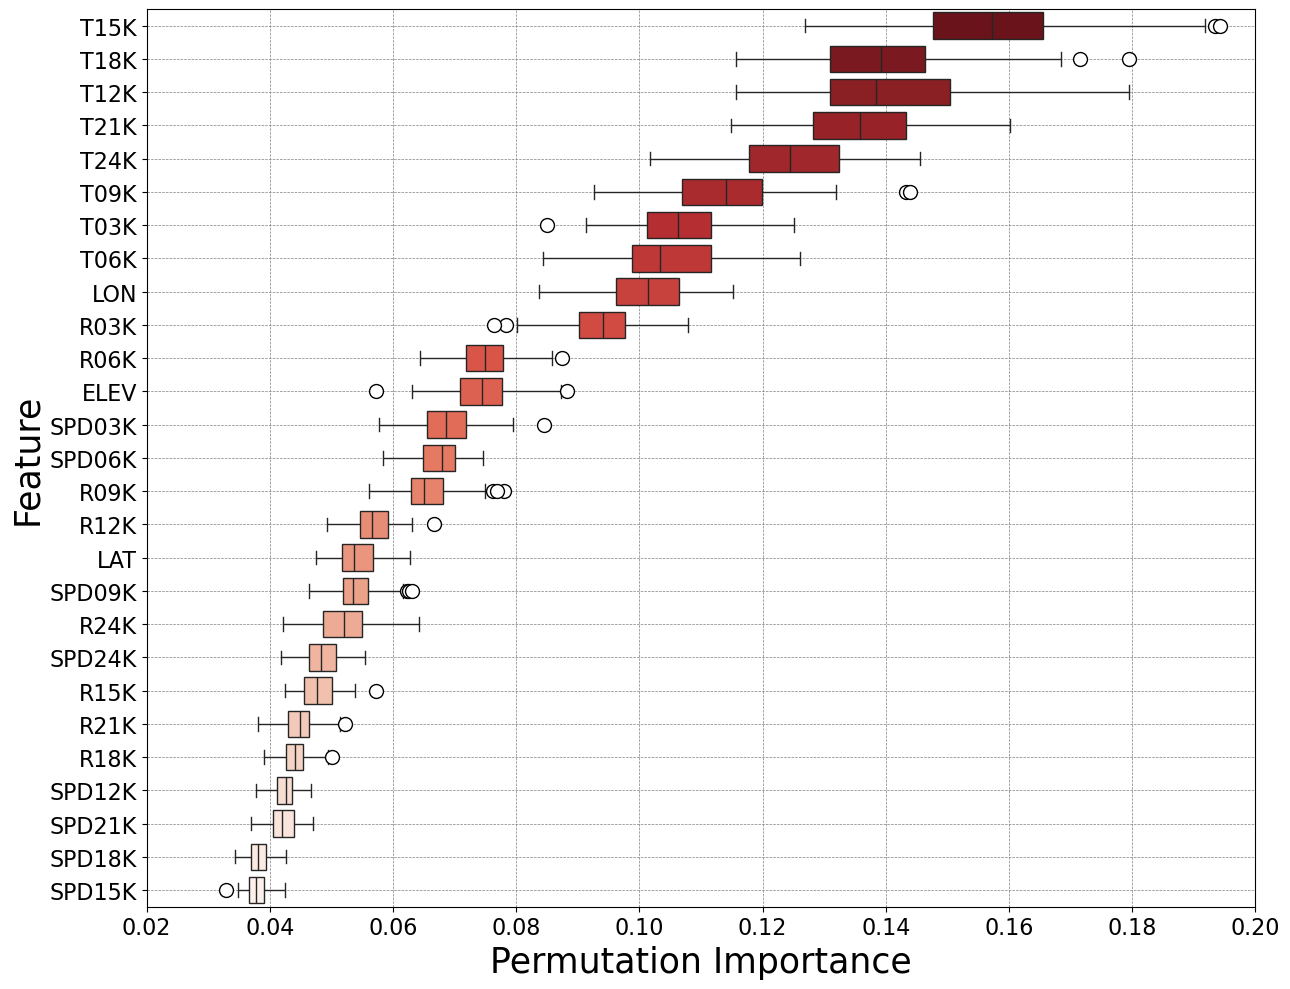

In [11]:
plt.figure(figsize=(13, 10))
df = df.rename(columns=lambda x: x.upper())
median_importances = df.median().sort_values(ascending = False).index.tolist()

# For coloring boxplots in order
colors = sns.color_palette("Reds_r", n_colors = len(median_importances))
ordered_colors = dict(zip(median_importances, colors))

sns.boxplot(
    data = df, 
    orient = 'h', 
    order = median_importances, 
    zorder = 10, 
    palette = palette_dict,
    flierprops={"marker" : "o", "markerfacecolor" : "w", "markeredgecolor" : "k", "markersize":10}
)

plt.xlabel('Permutation Importance', fontsize = 25)
plt.ylabel('Feature', fontsize = 25)
#plt.title('Random Forest Feature Permutation Importance', fontsize = 27)
plt.xticks(np.arange(0.02, 0.2 + 0.01, 0.02), size = 16) # np.arange(0, 0.045 + 0.0001, 0.005)
plt.xlim(0.02, 0.2) # plt.xlim(0, 0.045)
plt.yticks(size = 16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', zorder=0)
plt.margins(x = 0.025)
plt.tight_layout()